# Lab 3 - Joining Uber Pick-Ups, Stations, and Boroughs - SQL

FiveThirtyEight obtained information about all Uber pick-ups in NYC for two 6 month periods through a FOIA request.  More information about the data and subsequent analyses can be found [here](https://github.com/fivethirtyeight/uber-tlc-foil-response).

The combined data are too large for binder, so we have included a sample of 100,000 rows from each table.  In this exercise, you will join the base name and taxi zone name onto the original data from Jan-June 2015, add variaous date parts to the data, and finally aggregate the data to answer some questions about the frequency of Uber pick-ups.

The sampled data have been provided in the SQLite database named `uber_samples.db`.

In [2]:
%load_ext pyensae
%SQL_connect ./databases/uber_samples.db
%SQL_tables

['apr14',
 'aug14',
 'base_lookup',
 'janjune15',
 'jul14',
 'jun14',
 'may14',
 'sep14',
 'taxi_zone_lookup']

## <font color="red"> Problem 1 - Inspect the column names for the three tables of interest.

First, we will focus on the January-June 2015 data.  **Inspect the column schema for this table.**

In [3]:
%SQL_schema janjune15

{0: ('Dispatching_base_num', str),
 1: ('Pickup_date', datetime.datetime),
 2: ('Affiliated_base_num', str),
 3: ('locationID', int)}

The name taxi zone for each location is provided in `taxi-zone-lookup` and the Uber base station names can be found in `base_lookup`.  **Inspect the column schema for each table.**

In [4]:
%SQL_schema taxi_zone_lookup

{0: ('LocationID', int), 1: ('Borough', str), 2: ('Zone', str)}

In [5]:
%SQL_schema base_lookup

{0: ('base_code', str), 1: ('base_name', str)}

Your next task will be joining all the names onto the January-June 2015 data.  **Discuss the columns that will need to be joined.  What type of joins?**

* We need to join `base_lookup` to `janjune15` using `janjune15.Dispatching_base_num == base_lookup.base_code`
* We need to join `taxi_zone_lookup` to `janjune15` using `janjune15.locationID == taxi_zone_lookup.LocationID`

## <font color="red"> Problem 2 - Joining the tables</font>

**Use SQL to join the three tables together into one table.**

In [27]:
%%SQL
SELECT janjune15.Pickup_date,   base_lookup.base_name, taxi_zone_lookup.Borough, taxi_zone_lookup.Zone 
FROM janjune15 LEFT JOIN base_lookup ON janjune15.Dispatching_base_num == base_lookup.base_code LEFT JOIN taxi_zone_lookup ON janjune15.locationID == taxi_zone_lookup.LocationID 

,Pickup_date,base_name,Borough,Zone
0,2015-01-18 09:25:38.000000,Hinter,Manhattan,West Village
1,2015-05-17 11:44:00.000000,Weiter,Brooklyn,Brooklyn Heights
2,2015-05-17 11:46:00.000000,Weiter,Manhattan,Penn Station/Madison Sq West
3,2015-01-19 05:32:05.000000,Hinter,Manhattan,Clinton East
4,2015-01-19 22:28:20.000000,Hinter,Brooklyn,Carroll Gardens
5,2015-02-05 20:47:15.000000,Danach-NY,Manhattan,Lenox Hill West
6,2015-04-07 21:47:00.000000,Danach-NY,Manhattan,Midtown East
7,2015-06-16 16:28:00.000000,Schmecken,Manhattan,Morningside Heights
8,2015-06-16 16:33:00.000000,Schmecken,Manhattan,West Chelsea/Hudson Yards
9,2015-04-16 19:03:00.000000,Danach-NY,Manhattan,SoHo


## <font color="red"> Problem 3 - Adding Date Parts</font>

The questions in the next section ask questions about the hour of the day.  The hour can be compute using the `strftime` function using `strftime('%d', column)` in the `SELECT` statement.  **Use SQL to add the hour of the day and day of the week to the table**

In [28]:
%%SQL
SELECT janjune15.Pickup_date, strftime('%d', janjune15.Pickup_date) AS hour, base_lookup.base_name, taxi_zone_lookup.Borough, taxi_zone_lookup.Zone 
FROM janjune15 LEFT JOIN base_lookup ON janjune15.Dispatching_base_num == base_lookup.base_code LEFT JOIN taxi_zone_lookup ON janjune15.locationID == taxi_zone_lookup.LocationID 

,Pickup_date,hour,base_name,Borough,Zone
0,2015-01-18 09:25:38.000000,18,Hinter,Manhattan,West Village
1,2015-05-17 11:44:00.000000,17,Weiter,Brooklyn,Brooklyn Heights
2,2015-05-17 11:46:00.000000,17,Weiter,Manhattan,Penn Station/Madison Sq West
3,2015-01-19 05:32:05.000000,19,Hinter,Manhattan,Clinton East
4,2015-01-19 22:28:20.000000,19,Hinter,Brooklyn,Carroll Gardens
5,2015-02-05 20:47:15.000000,05,Danach-NY,Manhattan,Lenox Hill West
6,2015-04-07 21:47:00.000000,07,Danach-NY,Manhattan,Midtown East
7,2015-06-16 16:28:00.000000,16,Schmecken,Manhattan,Morningside Heights
8,2015-06-16 16:33:00.000000,16,Schmecken,Manhattan,West Chelsea/Hudson Yards
9,2015-04-16 19:03:00.000000,16,Danach-NY,Manhattan,SoHo


## <font color="red"> Problem 4 - Prototyping a Helper Function</font>

We are interested in answering the following questions.

1. Which of the Uber base stations dispatched the most calls?
2. Which of the Boroughs dispatched the most calls?
3. Is there a difference between the Boroughs in terms of the distribution of pick-ups across the hours of the day?

**Use SQL to answer the following questions.**

#### Question 1

In [31]:
%%SQL
SELECT base_name, cnt
FROM (
        SELECT base_name, count(*) AS cnt
        FROM (SELECT janjune15.Pickup_date, strftime('%d', janjune15.Pickup_date) AS hour, base_lookup.base_name, taxi_zone_lookup.Borough, taxi_zone_lookup.Zone 
              FROM janjune15 LEFT JOIN base_lookup ON janjune15.Dispatching_base_num == base_lookup.base_code LEFT JOIN taxi_zone_lookup ON janjune15.locationID == taxi_zone_lookup.LocationID)
        GROUP BY base_name)
ORDER BY cnt DESC

,base_name,cnt
0,Danach-NY,4051
1,Schmecken,2417
2,Weiter,1459
3,Hinter,1084
4,Grun,788
5,Unter,178
6,Dreist,22
7,Drinnen,1


#### Question 2

In [33]:
%%SQL
SELECT Borough, cnt
FROM (
        SELECT Borough, count(*) AS cnt
        FROM (SELECT janjune15.Pickup_date, strftime('%d', janjune15.Pickup_date) AS hour, base_lookup.base_name, taxi_zone_lookup.Borough, taxi_zone_lookup.Zone 
              FROM janjune15 LEFT JOIN base_lookup ON janjune15.Dispatching_base_num == base_lookup.base_code LEFT JOIN taxi_zone_lookup ON janjune15.locationID == taxi_zone_lookup.LocationID)
        GROUP BY Borough)
ORDER BY cnt DESC

,Borough,cnt
0,Manhattan,7265
1,Brooklyn,1631
2,Queens,954
3,Bronx,144
4,Staten Island,3
5,Unknown,3


#### Question 3

In [37]:
%%SQL --df=out
SELECT Borough, hour, count(*) AS cnt
FROM (SELECT janjune15.Pickup_date, strftime('%d', janjune15.Pickup_date) AS hour, base_lookup.base_name, taxi_zone_lookup.Borough, taxi_zone_lookup.Zone 
      FROM janjune15 LEFT JOIN base_lookup ON janjune15.Dispatching_base_num == base_lookup.base_code LEFT JOIN taxi_zone_lookup ON janjune15.locationID == taxi_zone_lookup.LocationID)
GROUP BY Borough, hour

,Borough,hour,cnt
0,Bronx,01,7
1,Bronx,02,7
2,Bronx,04,1
3,Bronx,05,3
4,Bronx,06,9
5,Bronx,07,6
6,Bronx,08,5
7,Bronx,09,5
8,Bronx,10,5
9,Bronx,11,4


In [38]:
out

,Borough,hour,cnt
0,Bronx,01,7
1,Bronx,02,7
2,Bronx,04,1
3,Bronx,05,3
4,Bronx,06,9
5,Bronx,07,6
6,Bronx,08,5
7,Bronx,09,5
8,Bronx,10,5
9,Bronx,11,4


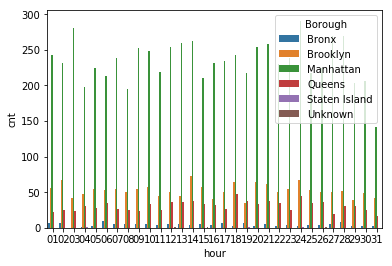

In [41]:
import seaborn as sns

sns.barplot(x='hour', y="cnt", hue ='Borough', data = out)